Load in packages relevant to function and SVM classifier 

In [42]:
# Load in packages
import gzip
import pandas as pd
import numpy as np
import time
import sklearn as sk
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import os
from os.path import exists
from collections import Counter
import math
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd
import time
import multiprocessing 

In [43]:
# Create empty lists to contain X and Y 
X = []
Y = []
# Load in data from RNA exp .gz files - uncompress to .tsv
cancer_type_list = ["BLCA","BRCA","CESC","COAD","GBM","HNSC","KIRC","KIRP","LAML","LGG","LIHC","LUAD","LUSC","OV","PAAD","PRAD","READ","SKCM","STAD","THCA","UCEC"]
for cancer_type in cancer_type_list:
    filename_gz = f'/Users/ngirmay//Downloads/exp_seq.{cancer_type}-US.tsv.gz'
    filename = f'/Users/ngirmay//Downloads/exp_seq.{cancer_type}-US.tsv'

    if not exists(filename) and exists(filename_gz):
        os.system(f"gunzip {filename_gz}")

    gene_list = []
    gene_file = "/Users/ngirmay/Downloads/genes.txt"
    with open(gene_file, 'r') as f:
        for line in f:
            gene_list.append(line.strip())

    # sample_dict = {"name1": {"gene_id":"normalized_gene_count"}} # create sample dict output that appears like this 
    sample_dict = {} # creating an empty dictionary that will contain sample name: gene id and normalized read count after looping through function
    with open(filename, "r") as f:
        for line in f:
            if line.startswith("icgc_donor_id"):
                continue
            lineList = line.strip().split("\t")
            sample = lineList[0]
            gene_name = lineList[7]

            if gene_name not in gene_list:
                continue

            normalized_gene_count = lineList[8]
            if sample not in sample_dict.keys(): # remove dupliicates
                sample_dict[sample] = {}
                sample_dict[sample][gene_name] = math.log2(max(float(normalized_gene_count), 0.00000001)) # log transform data
            else:
                sample_dict[sample][gene_name] = math.log2(max(float(normalized_gene_count), 0.00000001))
            

    for sample in sample_dict:
        sample_gene_values_integer_list = [] # save values as integers
        
        for gene in gene_list:
            sample_gene_values_integer_list.append(sample_dict[sample][gene])
        
        X.append(sample_gene_values_integer_list)
        Y.append(cancer_type)

    os.system(f"gzip {filename}") # gzip file 

Data will be split into training set and testing set

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=45)

In [45]:
# print the values and keys of y_train
print(Counter(y_train).values())
print(Counter(y_train).keys())

dict_values([696, 258, 280, 166, 100, 322, 288, 98, 289, 305, 295, 358, 174, 326, 190, 200, 330, 324, 149, 108, 106])
dict_keys(['BRCA', 'PRAD', 'LGG', 'CESC', 'READ', 'THCA', 'COAD', 'PAAD', 'STAD', 'SKCM', 'LUSC', 'KIRC', 'OV', 'HNSC', 'BLCA', 'LIHC', 'LUAD', 'UCEC', 'KIRP', 'GBM', 'LAML'])


In [46]:
# SVC 
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Results indicate an accuracy of 97% in determining tissue of origin across 21 cancer types using dataset from TCGA

In [47]:
# Print results of model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        BLCA       0.96      0.96      0.96       105
        BRCA       1.00      0.99      1.00       345
        CESC       0.99      0.89      0.94        93
        COAD       0.76      0.96      0.85       140
         GBM       1.00      0.98      0.99        51
        HNSC       1.00      1.00      1.00       155
        KIRC       0.97      0.97      0.97       160
        KIRP       0.95      0.95      0.95        73
        LAML       1.00      1.00      1.00        67
         LGG       1.00      1.00      1.00       159
        LIHC       0.99      0.98      0.98        94
        LUAD       0.93      0.98      0.95       148
        LUSC       0.98      0.90      0.94       133
          OV       1.00      1.00      1.00        88
        PAAD       1.00      0.95      0.98        44
        PRAD       1.00      1.00      1.00       117
        READ       0.75      0.28      0.41        54
        SKCM       0.95    

In [57]:
# Create list of first 21 f1-scores
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
f1_list_long =  list(report_df["f1-score"])
f1_list_short = f1_list_long[:21]
f1_list_short_formatted = [ '%.2f' % elem for elem in f1_list_short ]

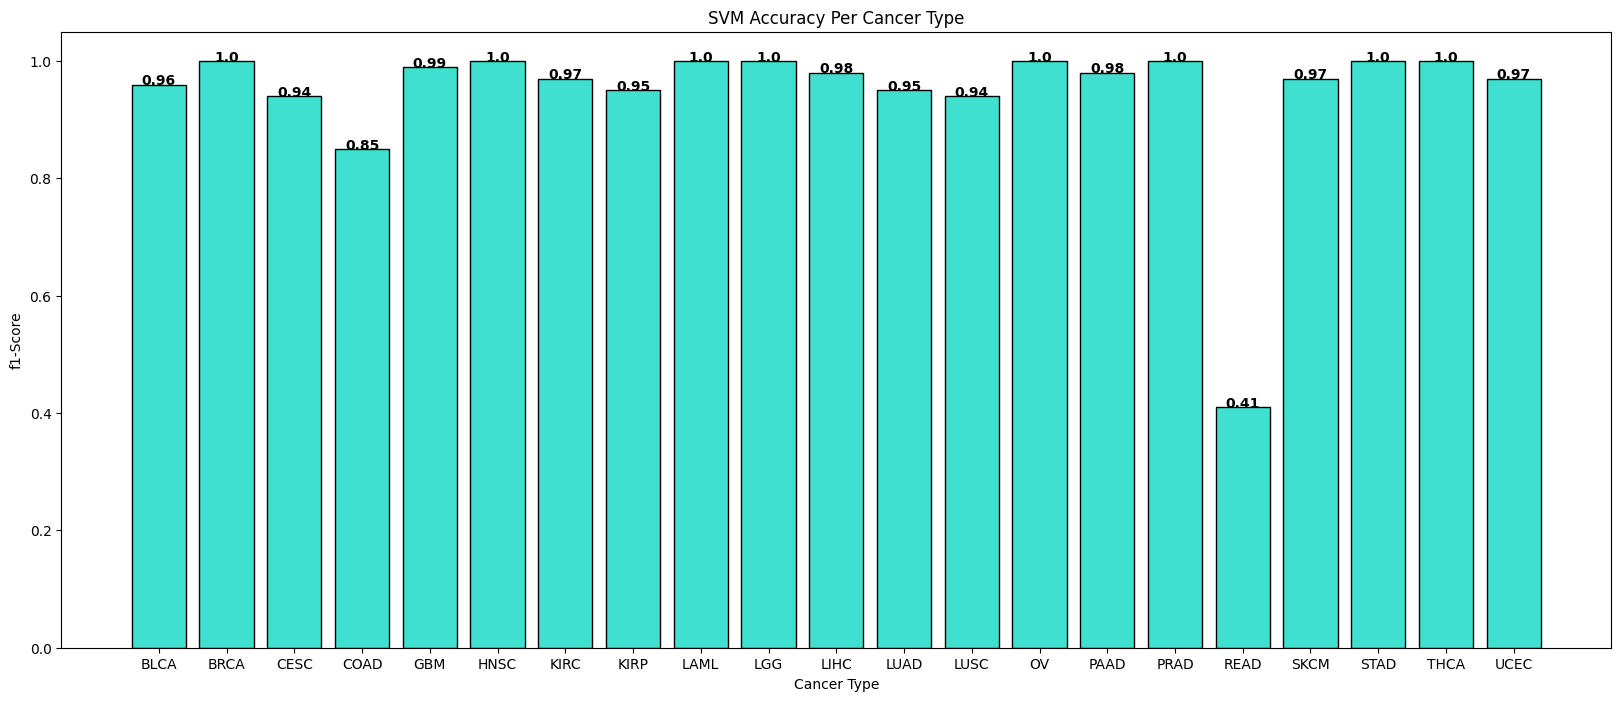

In [49]:
# Bar graph of F-1 scores by Cancer Type

plt.figure(figsize = (20,8))
cancer_type_labels = ["BLCA","BRCA","CESC","COAD","GBM","HNSC","KIRC","KIRP","LAML","LGG","LIHC","LUAD","LUSC","OV","PAAD","PRAD","READ","SKCM","STAD","THCA","UCEC"]
f1_scores = [float(i) for i in f1_list_short_formatted]
plt.bar(cancer_type_labels,f1_scores, fc = "turquoise", ec = "black")
plt.title('SVM Accuracy Per Cancer Type')
plt.xlabel('Cancer Type')
plt.ylabel('f1-Score')

for i, v in enumerate(f1_scores):
    plt.text(i, v, str(v), ha = "center", weight = "bold")

plt.show()

/var/folders/_w/k9b4brpx7hlfjm6btrrr148r0000gn/T/ipykernel_3089/2489817990.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cancer Type', y=metric, data=df, ax=ax, palette='viridis')
/var/folders/_w/k9b4brpx7hlfjm6btrrr148r0000gn/T/ipykernel_3089/2489817990.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cancer Type', y=metric, data=df, ax=ax, palette='viridis')
/var/folders/_w/k9b4brpx7hlfjm6btrrr148r0000gn/T/ipykernel_3089/2489817990.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cancer Type', y=metric, data=df, ax=ax,

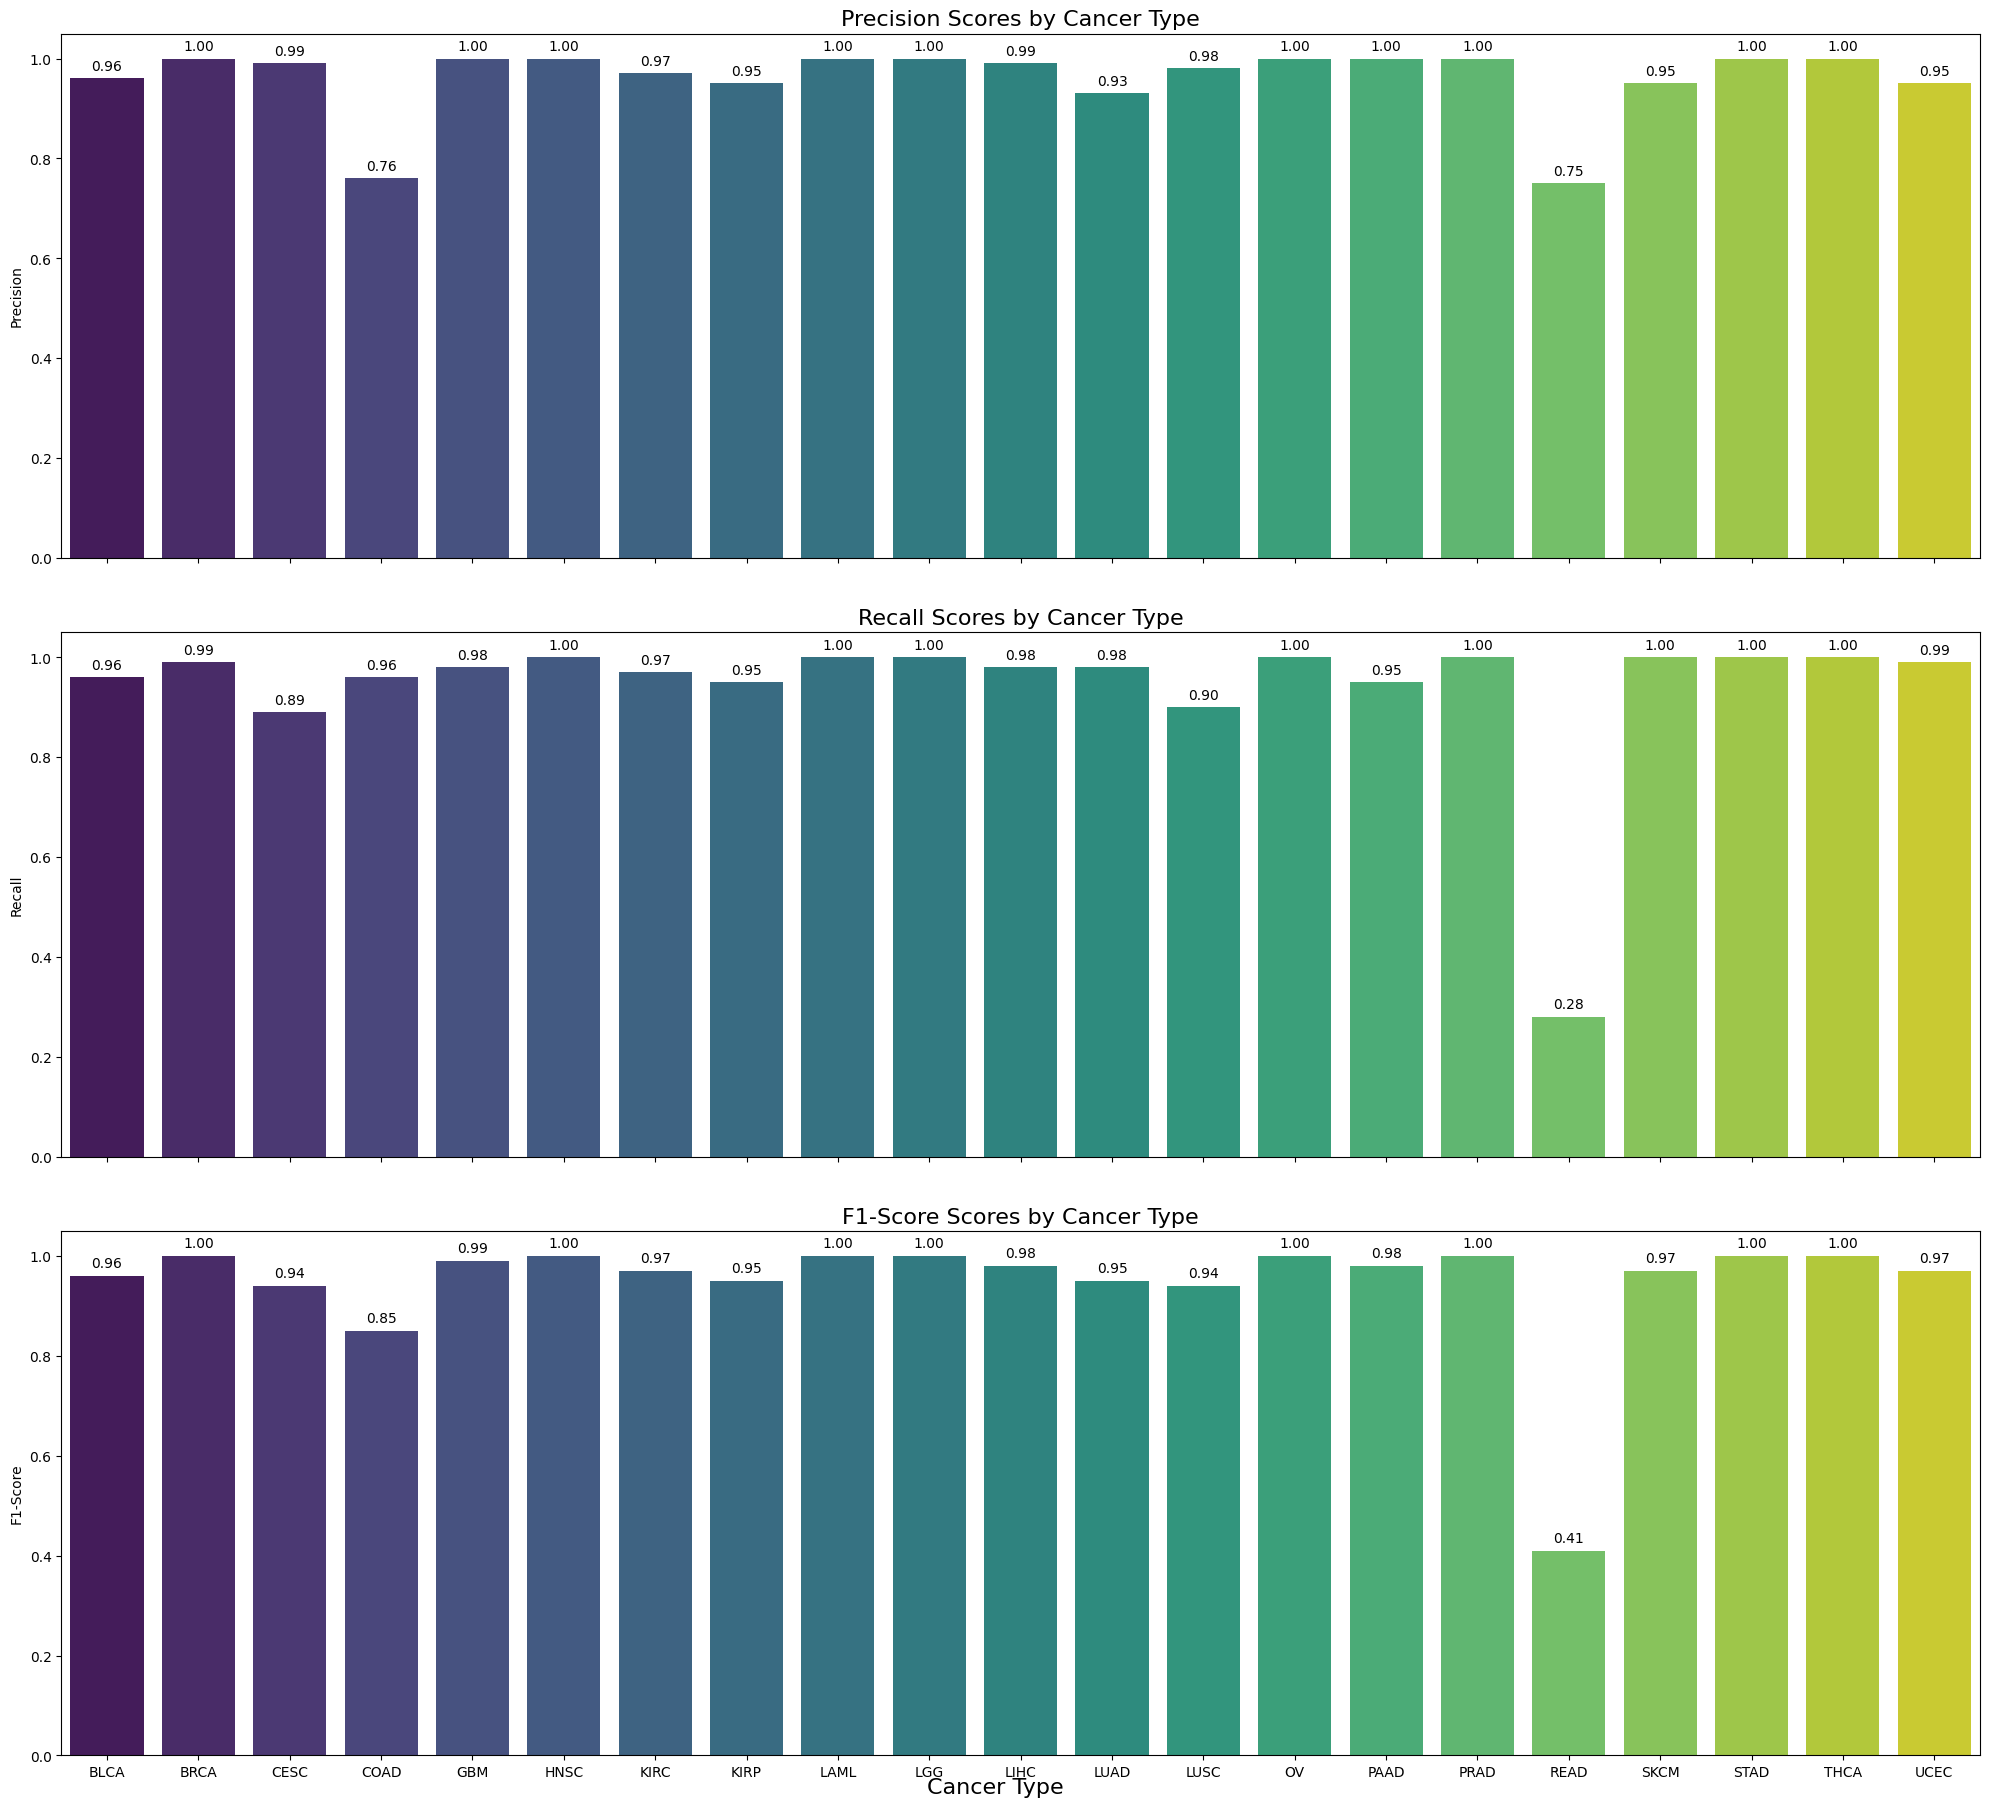

In [52]:
# Define the plotting function with annotations
def plot_metric(df, metric, ax):
    sns.barplot(x='Cancer Type', y=metric, data=df, ax=ax, palette='viridis')
    ax.set_title(f'{metric} Scores by Cancer Type', fontsize=16)
    ax.set_ylabel(metric)
    ax.set_xlabel('')

    # Add the text annotations on top of the bars
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'),  # Format the score to two decimal places
                    (p.get_x() + p.get_width() / 2., p.get_height()),  # Position for the annotation
                    ha='center', va='center',  # Center the text horizontally and vertically
                    xytext=(0, 9),  # Distance text is raised above the bar
                    textcoords='offset points',
                    fontsize=10)  # Font size of the annotation

# Create the subplots
fig, axes = plt.subplots(3, 1, figsize=(20, 18), sharex=True)

# Plot each metric with annotations
plot_metric(df, 'Precision', axes[0])
plot_metric(df, 'Recall', axes[1])
plot_metric(df, 'F1-Score', axes[2])

# Now set a common x-axis label
fig.text(0.5, 0.004, 'Cancer Type', ha='center', va='center', fontsize=16)
# Adjust the layout to give some space at the bottom
fig.tight_layout(h_pad=3.0)

# Figure
plt.savefig('/Users/ngirmay/Documents/GitHub/Bioinformatics/classification_report_visualization.png', dpi=300)

# Show the plot
plt.show()


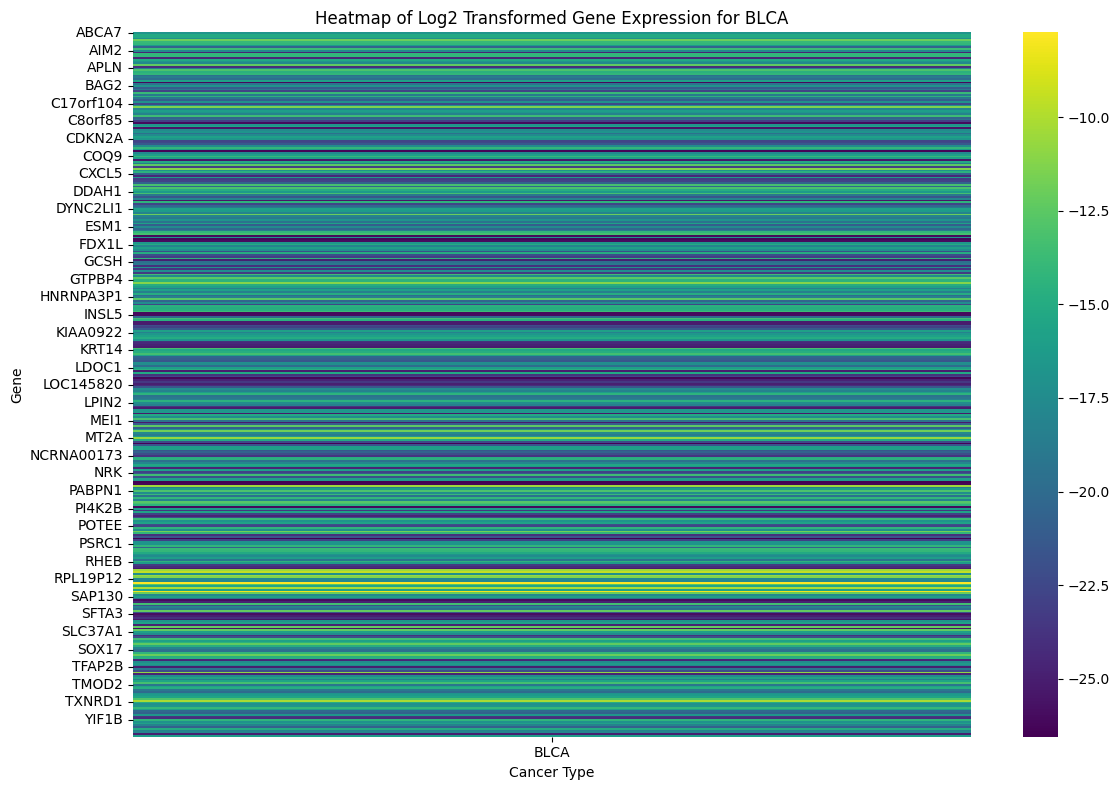

In [40]:
# Heat Map Test Case
# Set the directory where your files are located
directory = "/Users/ngirmay/Downloads/"
file_pattern = "exp_seq"
# Test with just one cancer type for the test case
cancer_type_list = ["BLCA"]  # Replace with a valid cancer type code for the test

# Load gene list
gene_list = []
gene_file = os.path.join(directory, "genes.txt")
with open(gene_file, 'r') as f:
    gene_list = [line.strip() for line in f]

# Process data for the test cancer type and create a DataFrame for the heatmap
heatmap_data_list = []

# Test case: process only one cancer type
cancer_type = cancer_type_list[0]
file_path = os.path.join(directory, f"{file_pattern}.{cancer_type}-US.tsv.gz")
if os.path.exists(file_path):
    # Read the data directly from the compressed file
    df = pd.read_csv(file_path, compression='gzip', sep='\t')
    # Filter by gene_list if needed
    df = df[df['gene_id'].isin(gene_list)]
    # Log2 transform and aggregate data
    df['log2_count'] = np.log2(df['normalized_read_count'].clip(lower=0.00000001))
    # Aggregate by gene
    gene_agg = df.groupby('gene_id')['log2_count'].mean().to_frame(name=cancer_type)
    heatmap_data_list.append(gene_agg)

# Combine all the aggregated data
heatmap_df = pd.concat(heatmap_data_list, axis=1)

# Generate the heatmap for the test case
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_df, cmap="viridis")
plt.title(f'Heatmap of Log2 Transformed Gene Expression for {cancer_type}')
plt.xlabel('Cancer Type')
plt.ylabel('Gene')
plt.tight_layout()
plt.show()

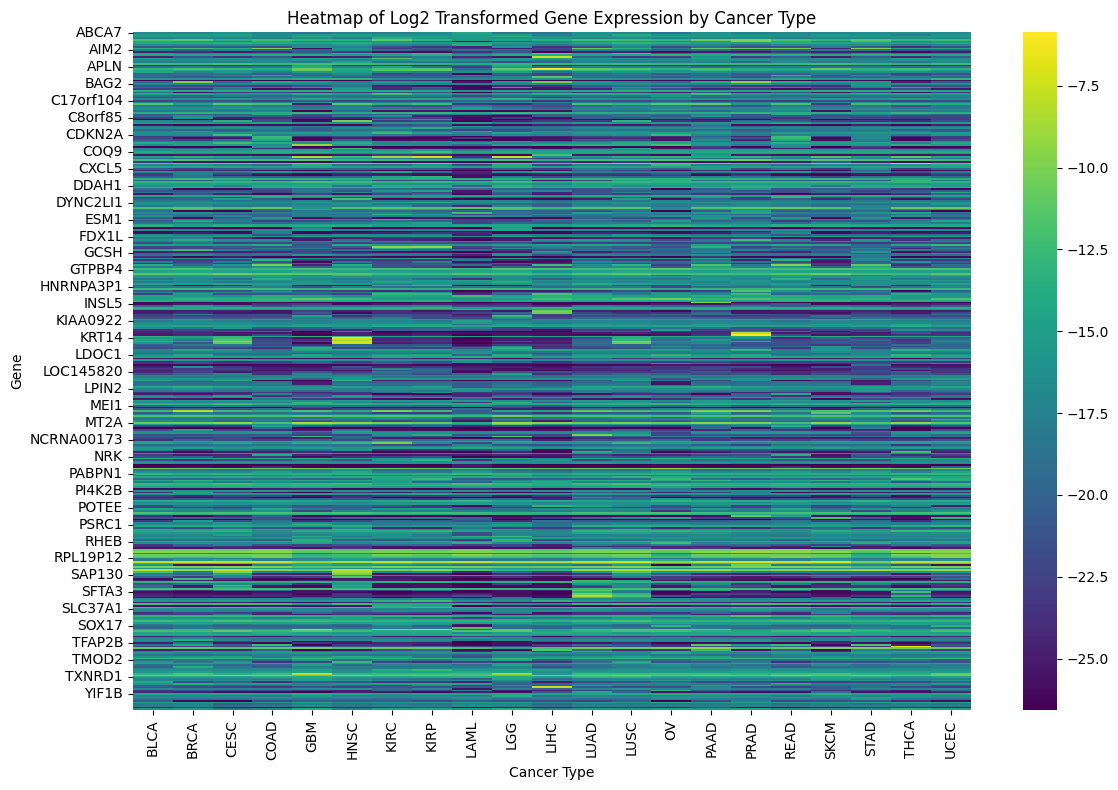

In [53]:
# Set the directory where your files are located
directory = "/Users/ngirmay/Downloads/"
file_pattern = "exp_seq"
cancer_type_list = ["BLCA","BRCA","CESC","COAD","GBM","HNSC","KIRC","KIRP","LAML","LGG","LIHC","LUAD","LUSC","OV","PAAD","PRAD","READ","SKCM","STAD","THCA","UCEC"]

# Load gene list
gene_list = []
gene_file = os.path.join(directory, "genes.txt")
with open(gene_file, 'r') as f:
    gene_list = [line.strip() for line in f]

# Process data for each cancer type and create a DataFrame for the heatmap
heatmap_data_list = []

for cancer_type in cancer_type_list:
    file_path = os.path.join(directory, f"{file_pattern}.{cancer_type}-US.tsv.gz")
    if os.path.exists(file_path):
        # Read the data directly from the compressed file
        df = pd.read_csv(file_path, compression='gzip', sep='\t')
        # Filter by gene_list if needed
        df = df[df['gene_id'].isin(gene_list)]
        # Log2 transform and aggregate data
        df['log2_count'] = np.log2(df['normalized_read_count'].clip(lower=0.00000001))
        # Aggregate by gene
        gene_agg = df.groupby('gene_id')['log2_count'].mean().to_frame(name=cancer_type)
        heatmap_data_list.append(gene_agg)

# Combine all the aggregated data
heatmap_df = pd.concat(heatmap_data_list, axis=1)

# HeatMap Generation
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_df, cmap="viridis")
plt.title('Heatmap of Log2 Transformed Gene Expression by Cancer Type')
plt.xlabel('Cancer Type')
plt.ylabel('Gene')
plt.tight_layout()

# Figure
output_file = '/Users/ngirmay/Documents/GitHub/Bioinformatics/heatmap_all_cancer_types.png'
plt.savefig(output_file, dpi=300)

# Display Plot
plt.show()


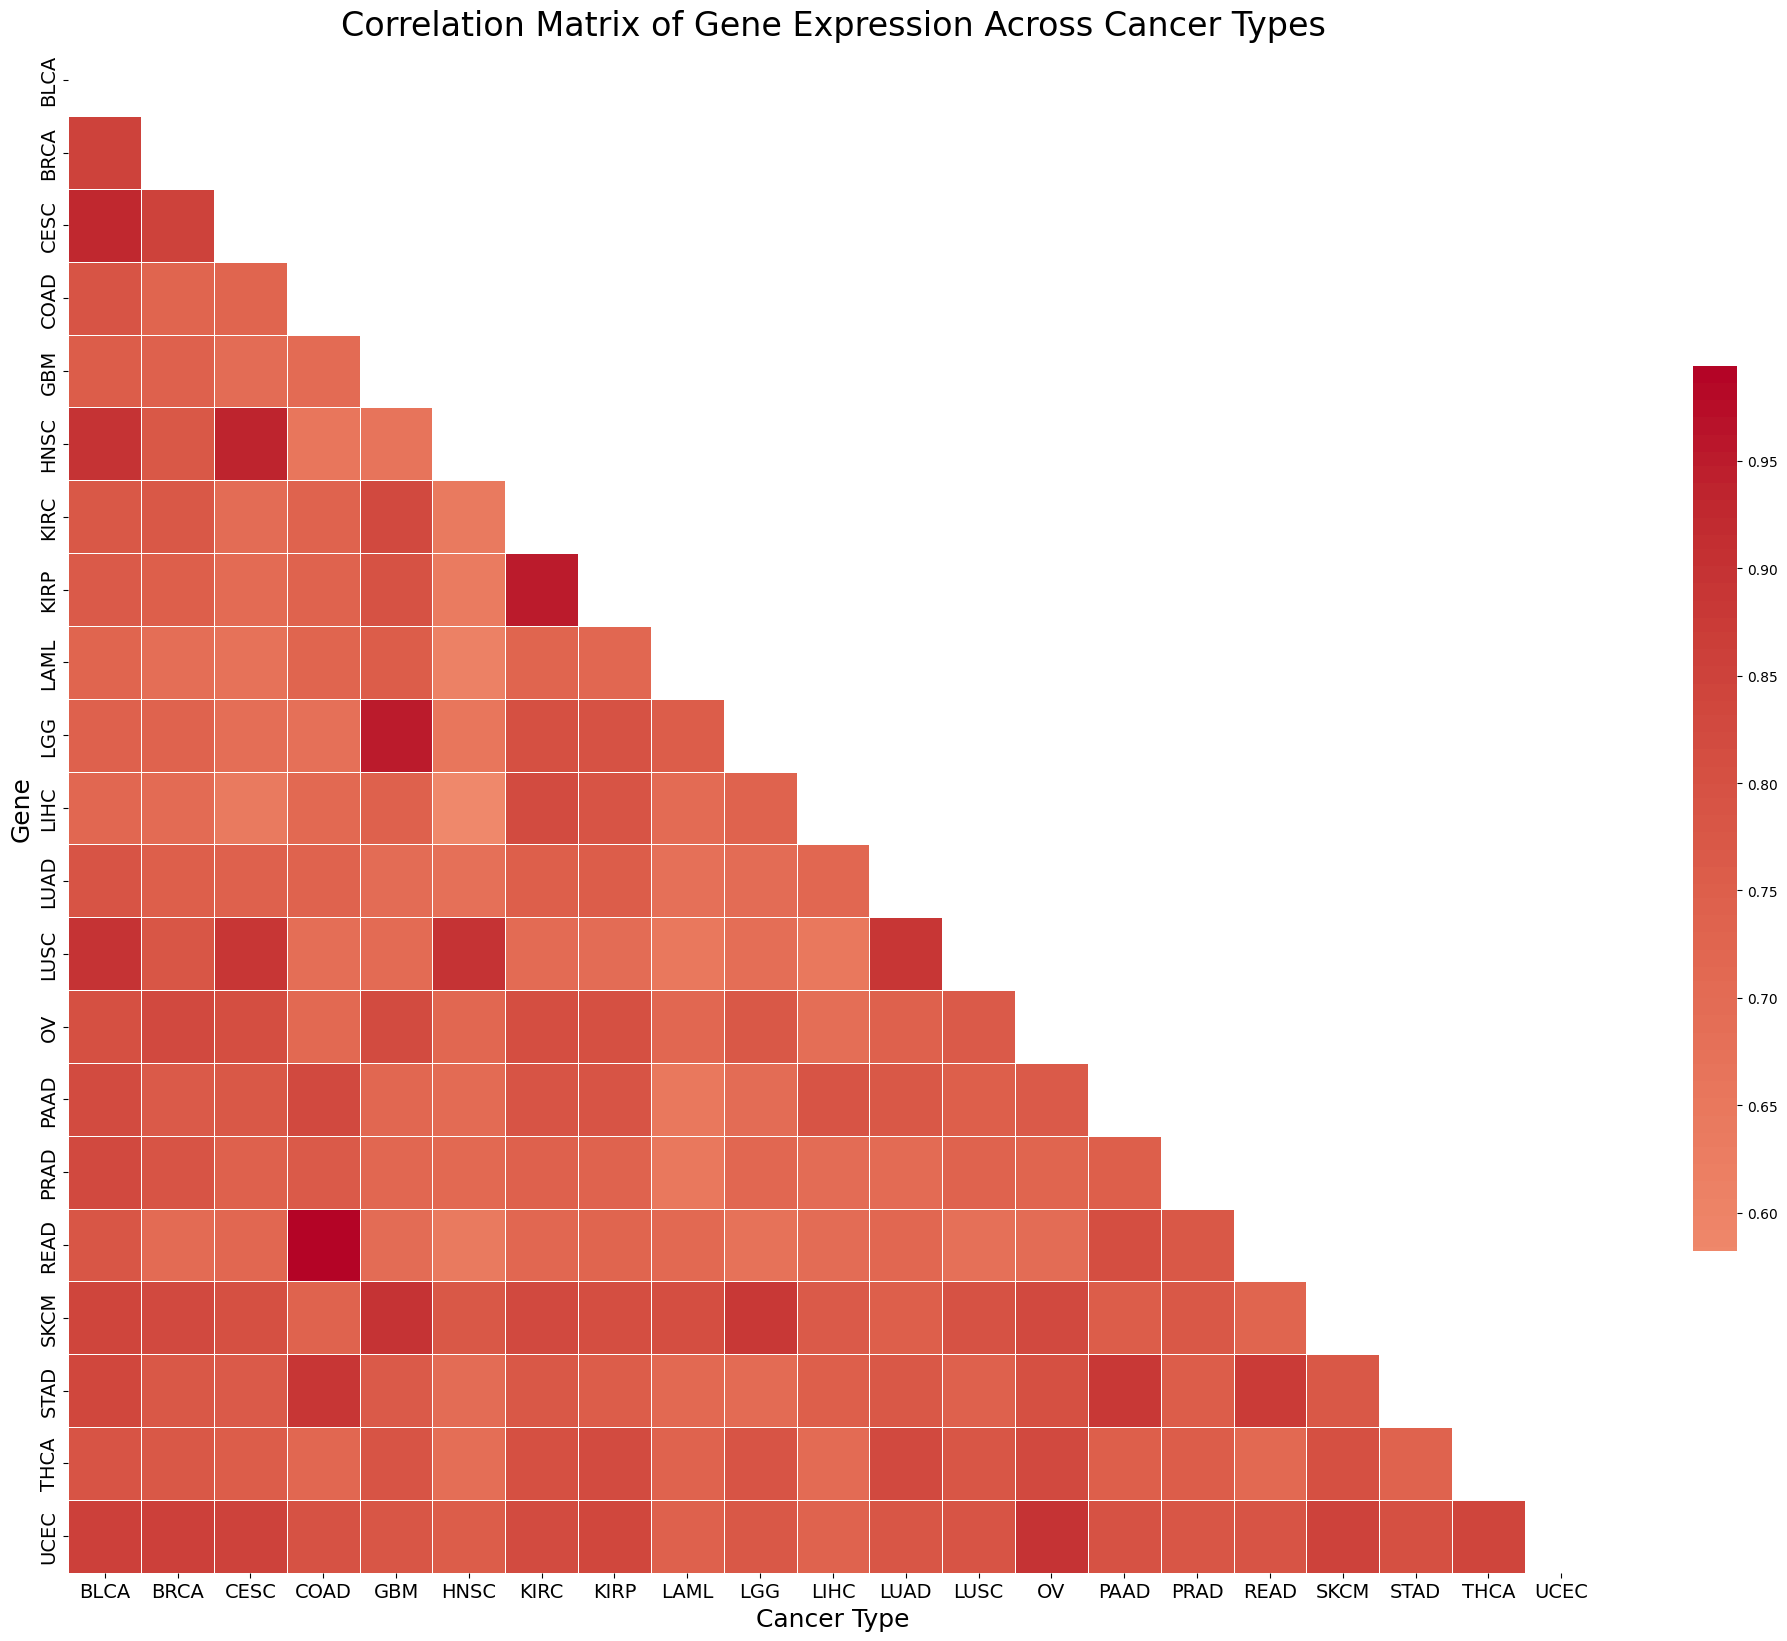

2023-11-13 01:37:36,809 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:53741', name: 0, status: running, memory: 0, processing: 0>
2023-11-13 01:37:37,221 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:53741'.
2023-11-13 01:37:37,285 - distributed.worker - ERROR - Scheduler was unaware of this worker 'tcp://127.0.0.1:53741'. Shutting down.
2023-11-13 01:37:37,411 - distributed.core - INFO - Connection to tcp://127.0.0.1:53698 has been closed.
2023-11-13 01:37:39,434 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-11-13 01:37:39,950 - distributed.nanny - WARNING - Restarting worker
2023-11-13 03:37:50,459 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:53746', name: 1, status: running, memory: 0, processing: 0>
2023-11-13 03:37:50,520 - distributed.scheduler - WARNING - R

In [56]:
# Correlation matrix Calculation
correlation_matrix = heatmap_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 18))  # Increase figure size for better readability

# Generate a mask for the upper triangle (optional)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# HeatMap Generation
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

# Figure
plt.title('Correlation Matrix of Gene Expression Across Cancer Types', fontsize=24)  # Increased font size
plt.xlabel('Cancer Type', fontsize=18)  # Increased font size
plt.ylabel('Gene', fontsize=18)  # Increased font size
plt.xticks(fontsize=14)  # Increase x-axis labels font size
plt.yticks(fontsize=14)  # Increase y-axis labels font size

plt.tight_layout()


output_file = '/Users/ngirmay/Documents/GitHub/Bioinformatics/correlation_matrix.png'
plt.savefig(output_file, dpi=300)

# Show the plot
plt.show()




Gene Expression Analysis Across Cancer Types
This report presents a series of visualizations that represent the gene expression data across various cancer types. The visualizations serve to operate under the python framework.

Heatmap of Log2 Transformed Gene Expression by Cancer Type
The heatmap illustrates the log2 transformed expression levels of genes across different cancer types. Each row represents a gene, and each column represents a cancer type, with color intensity indicating the expression level. The transformation helps to normalize the data and makes it easier to observe differences across the cancer types.

Main Takeaways:
Expression Patterns: Some genes show higher expression in certain cancer types which is expected, this could also be indicative of cancer-specific biological processes or pathways.
Potential Biomarkers: Genes with distinct expression profiles across cancer types may serve as potential biomarkers for diagnosis or targets for therapy. This is a common indicator for precision medicine and the ML method in use easily categorizes each cancer type within a range of expression levels

Correlation Matrix of Gene Expression Across Cancer Types
The correlation matrix provides a pairwise comparison of gene expression levels across cancer types, revealing how similar the expression profiles are between pairs of cancer types.

Main Takeaways:
Related Cancer Types: A strong positive correlation suggests that certain cancer types have similar gene expression profiles, indicating shared underlying mechanisms or common origins.
Diverse Expression: Conversely, cancer types with lower correlations might have unique expression profiles.

Classification Report Visualization
The bar plots display precision, recall, and F1-scores for the SVC model that predicts cancer types from gene expression data. Each bar represents a score for a particular cancer type.

Main Takeaways:
Model Performance: High scores across most cancer types indicate good model performance. However, certain types such as READ show lower scores, suggesting room for improvement depending on cancer type. 
Balanced Metrics: The F1-score combines precision and recall, providing a balanced view of the model's performance.
Deeper Analysis: Further investigation is needed into genes or cancer types with unique expression patterns to understand the biological significance.
Model Refinement: For cancer types with lower classification scores, additional features or alternative modeling techniques could be explored to improve performance.
Pathway Analysis: Integrating pathway information could give insights into the biological processes driving the observed expression patterns.